<a href="https://colab.research.google.com/github/leonardogolinelli/rna_velo_tests/blob/main/data_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def stochastic_model_onstage(t, alfa, beta, gamma):
  #analytical solution of the stochastic model in the on stage
  #in the on stage of the stochastic model, u and s are poisson distributed
  #with parameter a and b respectively

  #distribution parameters
  a = (alfa/beta) * (1-np.exp(-beta*t))
  b = (alfa/gamma)*(1-np.exp(-gamma*t))+(alfa/(gamma-beta))*(np.exp(-gamma*t)-np.exp(-beta*t))

  #distributions
  P_u = np.random.poisson(a)
  P_s = np.random.poisson(b)

  #expected values
  exp_u = a
  exp_s = b
  return P_u, P_s, exp_u, exp_s

In [ ]:
def stochastic_model_offstage(t, t_switch, u_switch, s_switch, beta, gamma, exp_u, exp_s):
  #analytical solution of the stochastic model in the off stage
  #in the off stage of the stochastic model u is binomial distributed, whereas s is
  #a sum of 2 binomial distributions

  #success probabilities
  p1 = np.exp(-beta*(t-t_switch))
  p2 = (beta/(beta-gamma))*((np.exp(-gamma*(t-t_switch))-np.exp(-beta*(t-t_switch)))/(1-np.exp(-beta*(t-t_switch)))) #correct if beta != gamma
  p3 = np.exp(-gamma*(t-t_switch))


  #distributions
  B_u = np.random.binomial(np.round(u_switch).astype(int), p1)
  B_k = np.random.binomial(np.round(u_switch*(1-p1)).astype(int), p2)
  B_n_k = np.random.binomial(np.round(s_switch).astype(int), p3)
  B_s = B_k + B_n_k

  #expected values
  exp_u = u_switch * p1
  exp_s = u_switch * (1-p1) * p2 + s_switch * p3

  return B_u, B_s, exp_u, exp_s

In [ ]:
def simulation(u0, s0, alfa, beta, gamma, t_final, n_simulated_data, relative_t_switch):

  #define the switch time
  step = t_final / n_simulated_data
  t_switch_index = np.round(relative_t_switch * n_simulated_data).astype(int)
  t_switch = np.round(step * t_switch_index).astype(int)

  #define linearly spaced time points for on and off stage
  t_range_on = np.linspace(0.01, t_switch, n_simulated_data)
  t_range_off = np.linspace(t_switch+0.001, t_final, n_simulated_data)

  #run deterministic and stochastic models
  u_stoch_on, s_stoch_on, exp_u_stoch_on, exp_s_stoch_on = stochastic_model_onstage(t_range_on, alfa, beta, gamma)

  #grep the last u and s values at the end of the on stage
  u_switch = exp_u_stoch_on[-1]
  s_switch = exp_s_stoch_on[-1]

  u_stoch_off, s_stoch_off, exp_u_stoch_off, exp_s_stoch_off = stochastic_model_offstage(t_range_off, t_switch, u_switch, s_switch, beta, gamma, u_stoch_on, s_stoch_on)

  #concatenate time and u,s values from on stage and off stage
  t = np.concatenate((t_range_on, t_range_off))
  exp_u_stoch = np.concatenate((exp_u_stoch_on, exp_u_stoch_off))
  exp_s_stoch = np.concatenate((exp_s_stoch_on, exp_s_stoch_off))
  u_stoch = np.concatenate((u_stoch_on, u_stoch_off))
  s_stoch = np.concatenate((s_stoch_on, s_stoch_off))

  return t, t_switch, exp_u_stoch, exp_s_stoch, u_stoch, s_stoch

In [ ]:
def plot_simulation(t, t_switch, exp_u_stoch, exp_s_stoch, u_stoch, s_stoch):

  #plot u,s as a function of t
  plt.figure(figsize=(12,6))
  plt.plot(t, exp_u_stoch, label='unspliced expected value')
  plt.plot(t, exp_s_stoch, label='spliced expected value')
  plt.scatter(t, u_stoch, s=5)
  plt.scatter(t, s_stoch, s=5)
  plt.axvline(x = t_switch, color='green', linestyle='--', label = 'switch time')
  plt.legend()
  plt.grid(True)
  plt.title("Analytical solution to stochastic model")

In [ ]:
def plot_phase_plane(t, t_switch, n_simulated_data, exp_u_stoch, exp_s_stoch, u_stoch, s_stoch):
  #plot s as a function of u
  plt.figure(figsize=(12,6))
  exp_u_stoch_on = exp_u_stoch[:n_simulated_data]
  exp_s_stoch_on = exp_s_stoch[:n_simulated_data]
  exp_u_stoch_off = exp_u_stoch[n_simulated_data:]
  exp_s_stoch_off = exp_s_stoch[n_simulated_data:]
  u_stoch_on = u_stoch[:n_simulated_data]
  s_stoch_on = s_stoch[:n_simulated_data]
  u_stoch_off = u_stoch[n_simulated_data:]
  s_stoch_off = s_stoch[n_simulated_data:]

  plt.plot(exp_u_stoch_on, exp_s_stoch_on, label='on stage expected value')
  plt.plot(exp_u_stoch_off, exp_s_stoch_off, label='off stage expected value')
  plt.scatter(u_stoch_on, s_stoch_on, s=5)
  plt.scatter(u_stoch_off, s_stoch_off, s=5)
  plt.scatter(exp_u_stoch_on[-1], exp_s_stoch_on[-1], s=80, label='switch')
  plt.text(exp_u_stoch_on[-1]+0.5, exp_s_stoch_on[-1]-0.1, f't_switch:{t_switch}')

  plt.legend()
  plt.grid(True)
  plt.title("Phase plane")

In [ ]:
def main(
  u0 = 0,
  s0 = 0,
  alfa = 20,
  beta = 1,
  gamma = 0.75,
  t_final = 15,
  n_simulated_data = 200,
  relative_t_switch = 0.5,
  periodic_alfa = False):

  t, t_switch, exp_u, exp_s, u_stoch, s_stoch = simulation(u0, s0, alfa, beta, gamma,
                                                           t_final, n_simulated_data,
                                                           relative_t_switch)

  plot_simulation(t, t_switch, exp_u, exp_s, u_stoch, s_stoch)
  plot_phase_plane(t, t_switch, n_simulated_data, exp_u, exp_s, u_stoch, s_stoch)


In [ ]:
def module(u0 = 0,
  s0 = 0,
  alfa = 20,
  beta = 1,
  gamma = 0.75,
  t_final = 15,
  n_simulated_data = 200,
  relative_t_switch = 0.5,
  periodic_alfa = False):

    t, t_switch, exp_u, exp_s, u_stoch, s_stoch = simulation(u0, s0, alfa, beta, gamma,
                                                           t_final, n_simulated_data,
                                                           relative_t_switch)

    return t, t_switch, exp_u, exp_s, u_stoch, s_stoch

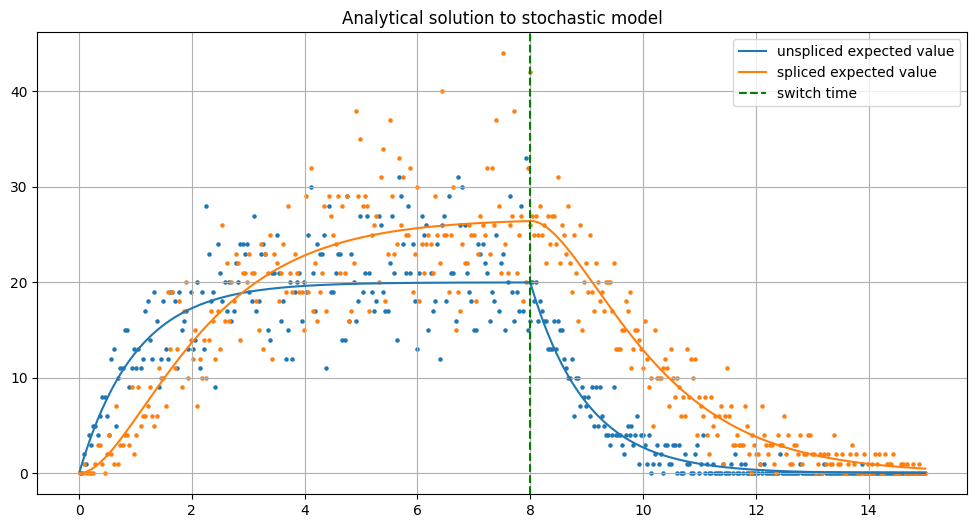

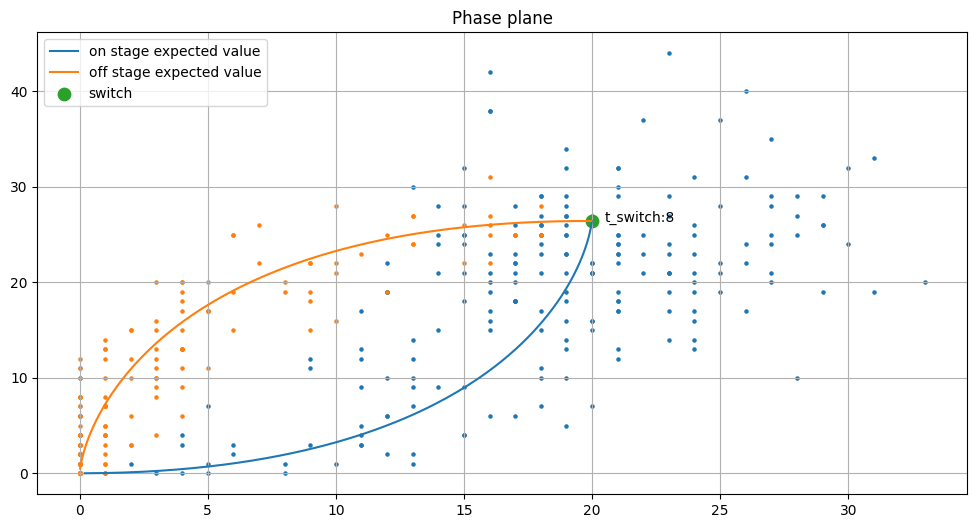

In [ ]:
if __name__ == "__main__":
  main()

else:
  module()
